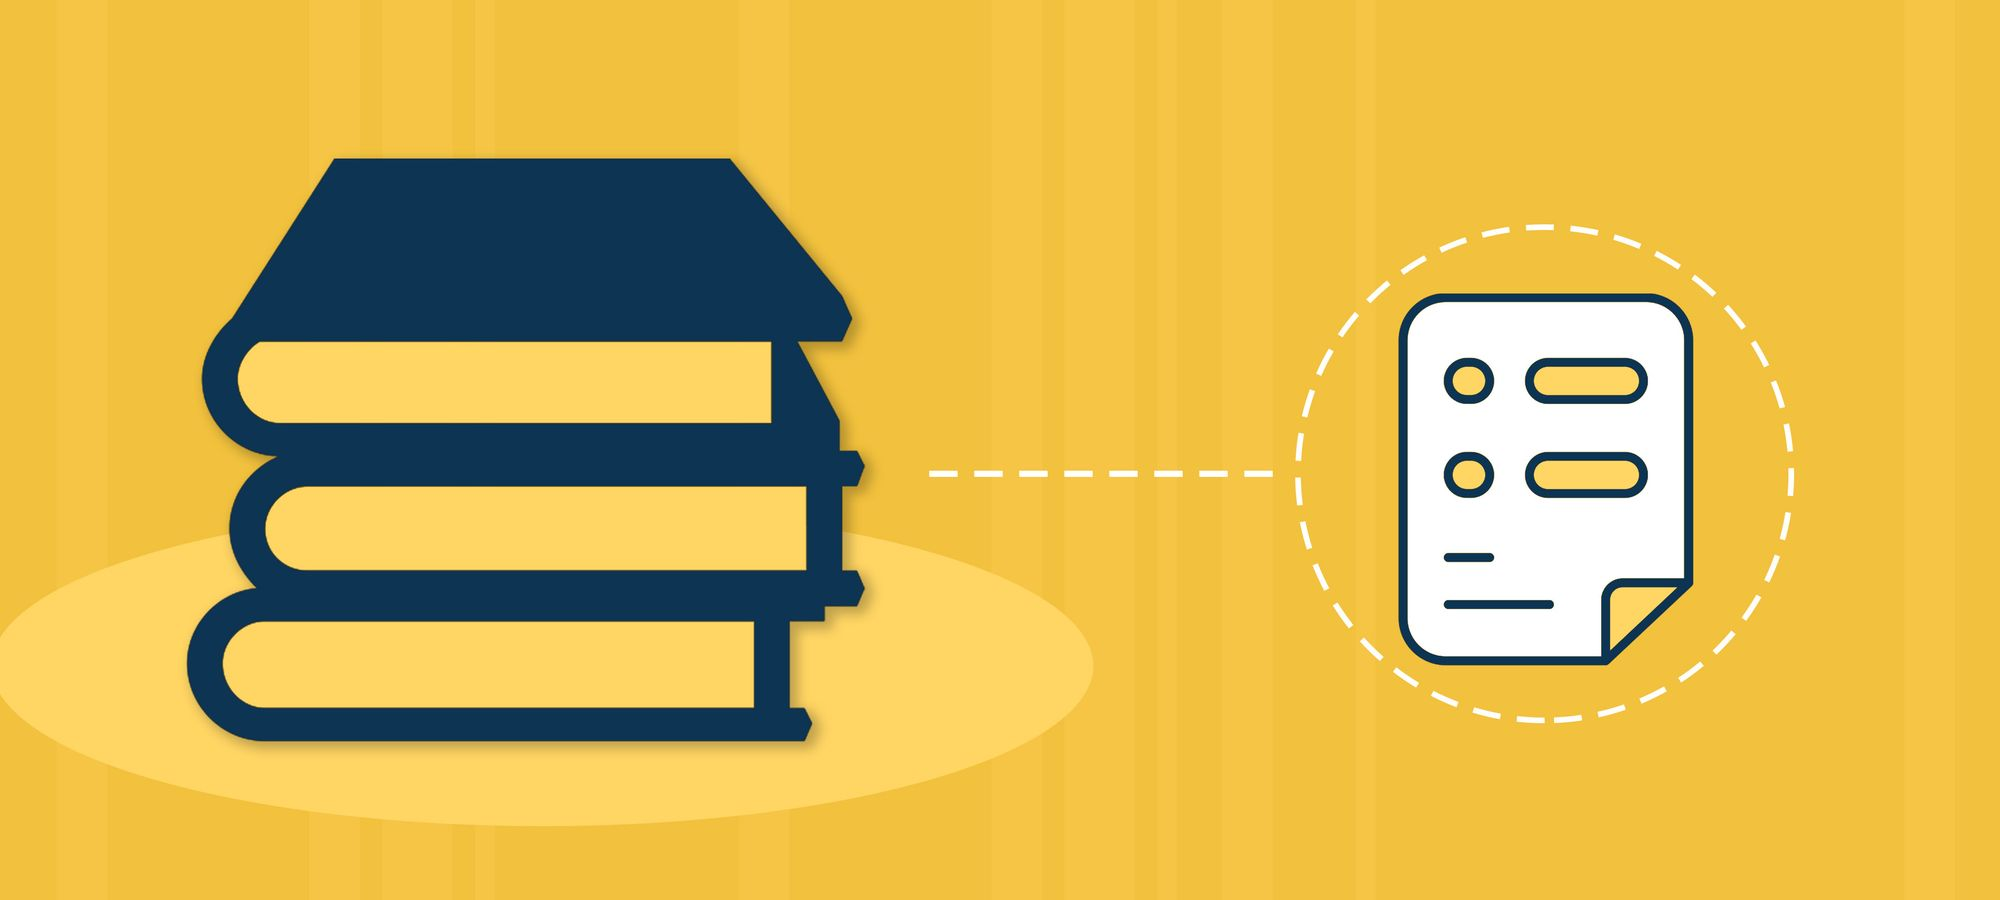

[Image source ](https://www.freecodecamp.org/news/how-to-build-a-text-summarizer-using-huggingface-transformers/)

<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
         <h2 style="color:#7689de">Installing the Dependencies and Libraries</h2>
    </div>
<div/>

In [1]:
!pip install contractions

  Obtaining dependency information for contractions from https://files.pythonhosted.org/packages/bb/e4/725241b788963b460ce0118bfd5c505dd3d1bdd020ee740f9f39044ed4a7/contractions-0.1.73-py2.py3-none-any.whl.metadata
  Obtaining dependency information for textsearch>=0.0.21 from https://files.pythonhosted.org/packages/e2/0f/6f08dd89e9d71380a369b1f5b6c97a32d62fc9cfacc1c5b8329505b9e495/textsearch-0.0.24-py2.py3-none-any.whl.metadata
  Obtaining dependency information for anyascii from https://files.pythonhosted.org/packages/4f/7b/a9a747e0632271d855da379532b05a62c58e979813814a57fa3b3afeb3a4/anyascii-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for pyahocorasick from https://files.pythonhosted.org/packages/4d/22/61283c423676443dd2f96cf6b886b26f21db3c869ae73432bf00d128bec0/pyahocorasick-2.1.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.6 MB/s eta 0:0

In [2]:
from concurrent.futures import ThreadPoolExecutor
from multiprocessing import cpu_count
import contractions
import re
import numpy as np
import pandas as pd
import os
from keras.layers import Dense, Input, LSTM, Embedding
from keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
   <p> code written down to just ignore the warnings
</p>
</div>
<div/>

In [3]:
import warnings
warnings.filterwarnings(action="ignore")

In [4]:
print(f"The number of cpu count: {cpu_count()}") # printing the cpu_count

The number of cpu count: 4


<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
         <h2 style="color:#7689de">Loading the Dataset</h2>
   <p> The dataset is expected to be in CSV format with columns 'text' and 'summary'. 
       <br>Note: Make sure to adjust the file path accordingly if not using Kaggle or change the file name if necessary</p>
</div>
<div/>

<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
         <p>We can see that we have 430 videos in <b>./DeepfakeTIMIT/higher_quality</b> folder and 320 videos in <b>./VidTIMIT</b> folder.<br>Now we have to move excess 110 videos into another directory.</p>
</div>
<div/>

In [56]:
data=pd.read_csv("/kaggle/input/asdfgh/all_data.csv",encoding="latin-1",usecols=["TEXT","SUMMARY"])

<div><div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
  About the data</div><div/>

In [57]:
print(f"Number of rows :{data.shape[0]}")
print(f"Number of columns :{data.shape[1]}")
# print(f"Number of text rows which doesn't have their summaries :{len(data[data["SUMMARY"].isna()])}")

Number of rows :318711
Number of columns :2


<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">DATA CLEANING</h2>
   <p> Resolved mixed types warning in data by selecting only the first two columns using data.iloc[:, 0:2] for improved compatibility.</p>
</div>
<div/>

In [58]:
data=data.iloc[:, 0:2]

<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
   <p>Extracted rows from 'data' DataFrame where 'SUMMARY' column values are missing (NaN) using <b>data["SUMMARY"].isna()</b></p>
</div>
<div/>

In [59]:
filtered_rows = data[data["SUMMARY"].isna()]
print(filtered_rows) 

                                                   TEXT SUMMARY
136   Air India's current business is "not sustainab...     NaN
231   A 27-year-old woman has told police that her i...     NaN
286   India captain Virat Kohli has said he is not a...     NaN
373   The US Transportation Security Administration ...     NaN
399   Indian golfer Diksha Dagar won a silver medal ...     NaN
...                                                 ...     ...
4362  Dong village in Arunachal Pradesh, which is kn...     NaN
4424  Biocon Chairperson Kiran Mazumdar-Shaw has cal...     NaN
4455  The Indian team got only 17 DRS referrals in t...     NaN
4501  Former Infosys CFO Mohandas Pai has said that ...     NaN
4509  A ticket collector on Thursday allegedly bit o...     NaN

[118 rows x 2 columns]


<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
   <p>We are getting 118 rows in which we don't have summaries<br>Removing them using <b>data.dropna()</b> keeping inplace=True</p>
</div>
<div/>

In [60]:
data.dropna(inplace=True)

<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
   <p>Checking if any null values present in ["TEXT"] column</p>
</div>
<div/>

In [61]:
data["TEXT"].isnull().sum()

0

<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
   <p>Checking if any null values present in ["SUMMARY"] column</p>
</div>
<div/>

In [62]:
data["SUMMARY"].isnull().sum()

0

<div>
     <div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
   <p>Extracting out 100 sample rows from our data</p>
</div>
<div/>

In [63]:
data = data.sample(100)

***


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVING USERNSMES, WRITER NAMES, PUBLISHING AND UPDATING DATE/TIME AND URLs</h2>
</div>
<div/>

In [64]:
# pat1 for name publisged and updated By . Bianca London . PUBLISHED: . 13:07 EST, 5 December 2013 . | . UPDATED: . 04:26 EST, 6 December 2013
pattern1= "By . [A-Za-z]+ [a-zA-Z\ ]+ . PUBLISHED: . [0-9]+:[0-9]+ EST, [0-9]+ [a-zA-Z]+ 20[0-9]+ . \| . UPDATED: . [0-9]+:[0-9]+ EST, [0-9]+ [a-zA-Z]+ 20[0-9]+ . "

# pat-2 for names with usernames 
pattern2="By . [A-Za-z]+ [a-zA-Z\s\-\_]+. [f-wF-W]+ @@[a-zA-Z\s\-\_0-9]+"

# pat3 for urls
pattern3="\b((?:https?://)?(?:(?:www\.)?(?:[\da-z\.-]+)\.(?:[a-z]{2,6})|(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)|(?:(?:[0-9a-fA-F]{1,4}:){7,7}[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,7}:|(?:[0-9a-fA-F]{1,4}:){1,6}:[0-9a-fA-F]{1,4}|(?:[0-9a-fA-F]{1,4}:){1,5}(?::[0-9a-fA-F]{1,4}){1,2}|(?:[0-9a-fA-F]{1,4}:){1,4}(?::[0-9a-fA-F]{1,4}){1,3}|(?:[0-9a-fA-F]{1,4}:){1,3}(?::[0-9a-fA-F]{1,4}){1,4}|(?:[0-9a-fA-F]{1,4}:){1,2}(?::[0-9a-fA-F]{1,4}){1,5}|[0-9a-fA-F]{1,4}:(?:(?::[0-9a-fA-F]{1,4}){1,6})|:(?:(?::[0-9a-fA-F]{1,4}){1,7}|:)|fe80:(?::[0-9a-fA-F]{0,4}){0,4}%[0-9a-zA-Z]{1,}|::(?:ffff(?::0{1,4}){0,1}:){0,1}(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])|(?:[0-9a-fA-F]{1,4}:){1,4}:(?:(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])\.){3,3}(?:25[0-5]|(?:2[0-4]|1{0,1}[0-9]){0,1}[0-9])))(?::[0-9]{1,4}|[1-5][0-9]{4}|6[0-4][0-9]{3}|65[0-4][0-9]{2}|655[0-2][0-9]|6553[0-5])?(?:/[\w\.-]*)*/?)\b"

# pat-4 for names -> By . Emma Glanfield For Mailonline 
# By . Katie Silver, Tamara Cohen and Chris Brooke
pattern4="[A-Ba-bY-Zy-z]+ . [A-Za-z]+ [a-zA-Z\ \,]+ "

# remove the non-ascii characters
pattern5= r'[^\x00-\x7F]'

# (CNN) -- OR (fast company) -- forget ashton kutch
pattern6 = r"(.+?) -- "


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVING PATTERN 1
</h2>
</div>
<div/>

In [65]:
def remove_pattern1_data(input_string):
    return re.sub(pattern=pattern1, repl='', string=input_string)


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVING PATTERN 2
</h2>
</div>
<div/>

In [66]:
def remove_pattern2_data(input_string):
    return re.sub(pattern=pattern2, repl='', string=input_string)


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVING PATTERN 3
</h2>
</div>
<div/>

In [67]:
def remove_pattern3_data(input_string):
    return re.sub(pattern=pattern3, repl='', string=input_string)


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVING PATTERN 4
</h2>
</div>
<div/>

In [68]:
def remove_pattern4_data(input_string):
    return re.sub(pattern=pattern4, repl='', string=input_string)



<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVE NON-ASCII CHARACTER
</h2>
</div>
<div/>

In [69]:
def remove_non_ascii(input_string):
    # Using regex to match non-ASCII characters and replace them with an empty string
    return re.sub(pattern=pattern5, repl='', string=input_string)

<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVE NEW LINE CHARACTER
</h2>
</div>
<div/>

In [70]:
def remove_newline_char(input_string):
    # Using regex to replace newline characters with an empty string
    return re.sub(r'\n', '', input_string)


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">REMOVING REMAINING NOISE
</h2>
</div>
<div/>

In [71]:
def remove_remaining_noise(input_string):
    return re.sub(pattern=pattern6, repl="", string=input_string, flags=re.IGNORECASE)


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">NORMALISING(Text/Summary)
</h2>
</div>
<div/>

In [72]:
def normalize_data(input_string):
    return input_string.lower()

 
<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">EXPAND CONTRACTIONS
</h2>
</div>
<div/>

In [73]:
def expand_contractions(input_string):
    return contractions.fix(input_string)


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">ADDING TOKENS
</h2>
      <p>adding &lt;SOSTOK&gt; at the start of the sentence and &lt;EOSTOK&gt; at the end of the sentence<br>They'll act as a sentence boundary</p>
</div>
<div/>

In [74]:
def start_end_token(input_string):
    return "<SOSTOK>"+input_string+"<EOSTOK>"

*******



<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
    <h2 style="color:#7689de">EXECUTING ALL THE ABOVE FUNCTIONS
</h2>
         <p> Using Thread Pool Executor for parallel processing</p>
        <p>Applying the function on both the columns i.e. ["TEXT"] and ["SUMMARY"].<br>This ensures that data cleaning occurs in both the columns</p>
</div>
<div/>

In [75]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(remove_pattern1_data,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_pattern1_data,list(data["SUMMARY"])))

In [76]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(remove_pattern2_data,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_pattern2_data,list(data["SUMMARY"])))

In [77]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:

    data["TEXT"]=list(pool.map(remove_pattern3_data,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_pattern3_data,list(data["SUMMARY"])))

In [78]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(remove_pattern4_data,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_pattern4_data,list(data["SUMMARY"])))

In [79]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(remove_non_ascii,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_non_ascii,list(data["SUMMARY"])))

In [80]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(remove_newline_char,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_newline_char,list(data["SUMMARY"])))

In [81]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(remove_remaining_noise,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(remove_remaining_noise,list(data["SUMMARY"])))

In [82]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool: 
    data["TEXT"]=list(pool.map(normalize_data,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(normalize_data,list(data["SUMMARY"])))

In [83]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["TEXT"]=list(pool.map(expand_contractions,list(data["TEXT"])))
    data["SUMMARY"]=list(pool.map(expand_contractions,list(data["SUMMARY"])))

<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
         <p>Applying <b> "start_end_token"</b> function only on ["SUMMARY"] column</p>
         <p>The reason these tokens are often applied to the summary column and not the text column is based on the nature of the task:

Start of Sequence <b>&lt;sostok&gt;</b>:

In the summary column, <b>&lt;sostok&gt;</b> signifies the start of the summary. This helps the model learn to generate summaries from the beginning, making it aware that it needs to start creating a concise representation of the input text.<br> <br>
End of Sequence <b>&lt;eostok&gt;</b>:

In the summary column, <b>&lt;eostok&gt;</b> signifies the end of the summary. This is crucial for training the model to generate summaries of variable lengths. The presence of <b>&lt;eostok&gt;</b> helps the model understand when it has generated a complete summary.</p>
         
<p> the text column typically doesn't need special tokens like <b>&lt;sostok&gt;</b> and <b>&lt;eostok&gt;</b> because it doesn't have a sequential generation task. The input text is usually processed as a whole, and the model is tasked with understanding the content or context of the entire input.</p>
</div>
</div>


In [84]:
with ThreadPoolExecutor(max_workers=os.cpu_count()) as pool:
    data["SUMMARY"]=list(pool.map(start_end_token,list(data["SUMMARY"])))


<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
      <p>Let's check the results after executing all the functions</p>
</div>
<div/>

In [85]:
data.sample(2)

,TEXT,SUMMARY
290838,"and the investor, these days, they want the sh...",<SOSTOK>filmmaker michael moore takes on capit...
242504,. last updated at 1:57 am on 4th december 2011...,<SOSTOK>mother and sister's fury over blunders...



<div>
     <div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
         <p>finding those data in which length of summary is greater than the text
</p>
</div>
<div/>

In [86]:
data["SUMMARY"]

239172    <SOSTOK>the new menu will feature four meal op...
5659      <SOSTOK>jose callejon finished a neat one-on-o...
165925    <SOSTOK>oriella caszzenello paid 10,000 for an...
253422    <SOSTOK>smith's doctors are charged with using...
309848    <SOSTOK>letters were kept in an area of the ar...
                                ...                        
26227     <SOSTOK>dania gharaibeh: condemning the act an...
139011    <SOSTOK>thieves were caught on cctv stripping ...
31721     <SOSTOK>new: low visibility causes ground dela...
86288     <SOSTOK>john paul atchison, 39, is best friend...
82488     <SOSTOK>england beat india by three runs in on...
Name: SUMMARY, Length: 100, dtype: object

In [87]:
condition=data["SUMMARY"].str.len()>=data["TEXT"].str.len()

In [88]:
data=data[~condition]

In [89]:
data.shape

(97, 2)

In [90]:
data[data["SUMMARY"].str.len()>=data["TEXT"].str.len()]

,TEXT,SUMMARY


<div>
<div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<h2 style="color:#7689de">ENCODING THE DATA
</h2>
<p>Creating an instance of Tokenizer class<p>
</div>
<div/>

In [91]:
tokenizer_text = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None,) # creating a instance of Tokenizer()

<div>
<div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<p>Applying the created instance of Tokenizer class on ["TEXT"] column using "tokenizer_text.fit_on_texts(data["TEXT"])"<br><br>
"fit_on_texts()" assigns a unique index to each unique word based on their frequency in the texts and constructs a vocabulary, where each word is associated with a unique index. The most frequent word gets index 1, the second most frequent gets index 2, and so on.<br><br>
Finding the size of the vocabulary and storing it into "vocab_size_text".
<p>
</div>
<div/>

In [92]:
tokenizer_text.fit_on_texts(data["TEXT"]) # using created instance on ["TEXT"] column using "fit_on_texts"
vocab_size_text = len(tokenizer_text.word_index) + 1 # determining the vocabulary size of the "TEXT" column
# +1 is for oov token, 
# len(tokenizer_text.word_index) gives the number of unique words in the vocabulary(indexed from 1) 
# but we want an additional token to tackle oov problem or for padding and '0' is reserved for that

In [93]:
print(f"Top 10 words from the vocabulary of the 'TEXT' column::\n")
list(tokenizer_text.word_index.items())[0:10]

Top 10 words from the vocabulary of the 'TEXT' column::



[('the', 1),
 ('to', 2),
 ('a', 3),
 ('of', 4),
 ('and', 5),
 ('in', 6),
 ('was', 7),
 ('that', 8),
 ('is', 9),
 ('for', 10)]

<div>
<div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<p>Repeating the above process for the "SUMMARY" column
    <ul>
        <li> Creating a instance of Tokenizer class.</li>
     <li> Using "fit_on_texts" to create a vocabulary from the "TEXT" column.</li>
     <li>Fining the length of the vocabulary and storing it into "vocab_size_summary".</li>
    </ul>
<p>
</div>
<div/>

In [94]:

### applying tokenizer on "SUMMARY" 

tokenizer_summary = Tokenizer(
    num_words=None,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True,
    split=' ',
    char_level=False,
    oov_token=None,
    analyzer=None,)


tokenizer_summary.fit_on_texts(data["SUMMARY"])
vocab_size_summary = len(tokenizer_summary.word_index) + 1

<div>
<div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<h2 style="color:#7689de">CONVERTING THE TEXT INTO SEQUENCES
</h2>
<p>
    Converting a list of texts into sequences of integers, where each integer represents the index of a word in the vocabulary using "texts_to_sequences()" method of Tokenizer() class.<br>
  Doing this for both the columns-> TEXT and SUMMARY
<p>
</div>
<div/>

In [95]:
text_sequences = tokenizer_text.texts_to_sequences(data["TEXT"])
summary_sequences = tokenizer_summary.texts_to_sequences(data["SUMMARY"])

<div>
<div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<p>
Let's take a look how our first summary look after tokenization and converting into a sequence.
<p>
</div>
<div/>

In [96]:
print("The first summary:\n\n"+ data["SUMMARY"].iloc[0],end="\n\n")
print(f"The tokenized first summary\n\n{summary_sequences[0]}")

The first summary:

<SOSTOK>the new menu will feature four meal options instead of the previous two .wagyu beef and a chicken salad will be among the first meals offered .passengers can also choose from snacks like beef sliders or weis bars .<EOSTOK>

The tokenized first summary

[5, 1, 24, 592, 46, 286, 164, 593, 594, 287, 3, 1, 595, 47, 596, 288, 8, 7, 597, 598, 46, 33, 599, 1, 40, 600, 601, 602, 111, 52, 603, 20, 604, 165, 288, 605, 71, 606, 607, 6]


<div>
<div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<p>
Finding the maximum sequence length of "TEXT" and "SUMMARY" column
<p>
</div>
<div/>

In [97]:
max_seq_len_text=len(max(list(data["TEXT"]), key=len))
print(f"max length of text column :{max_seq_len_text}")
max_seq_len_summary=len(max(list(data["SUMMARY"]), key=len))
print(f"max length of summary column :{max_seq_len_summary}")

max length of text column :8874
max length of summary column :665


<div>
<div style="font-family:Sans-serif; font-size:25px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<p>
Preparing the training and testing data for a sequence-to-sequence model, where you're creating input-output pairs for training. The sequences in vectorize_test_data lack the starting token ("&lt;sostok&gt;"), and the sequences in vectorize_train_data lack the ending token ("&lt;eostok&gt;")<br> 
<br>Both the test and train vectorized data will lack one token
  <p>
</div>
<div/>

In [98]:
for s in summary_sequences:
    print(len(s))

40
51
73
52
63
42
45
35
51
36
45
80
61
32
37
52
47
38
55
81
95
56
38
97
51
31
54
51
67
54
24
54
32
42
44
43
42
70
84
40
38
59
43
68
47
79
54
37
83
57
29
32
63
41
39
45
40
105
65
34
53
43
42
40
38
51
63
49
57
109
34
48
42
41
42
54
40
48
47
24
41
52
45
57
33
47
23
41
107
48
40
38
54
68
44
40
45


In [99]:
vectorize_test_data=[]
vectorize_train_data=[]

for seq in summary_sequences:
    vectorize_test_data.append(seq[1:]) # select the sequence after the 1st token
    vectorize_train_data.append(seq[:-1]) # # select the whole sequence leaving the last token
    
# They both should have same size because both of them lacks one token(either <sostok> or <eostok>)
print(f"The length of vectorized summary :{len(summary_sequences[0])}")
print(f"The length of first vectorized test data :{len(vectorize_test_data[0])}")
print(f"The length of first vectorized train data :{len(vectorize_train_data[0])}")

The length of vectorized summary :40
The length of first vectorized test data :39
The length of first vectorized train data :39


<div>
<div style="font-family:Sans-serif; font-size:20px; color:#a9dce3;background-color:#212121;padding:20px;border-radius:5px">
<h2 style="color:#7689de">PADDING THE DATA
</h2>
<p>
Padding is performed to make your input data uniform
"padding='post' " will add the zeroes at the last of the text sequence
<br><br>
And we'll give "max_seq_len_summary" as an upper value to which we pad the text sequence
<p>
</div>
<div/>

In [100]:
# PADDING THE DATA 

padded_text_sequences = pad_sequences(text_sequences, maxlen=max_seq_len_text, padding='post')
padded_test_summary_sequences = pad_sequences(vectorize_test_data, maxlen=max_seq_len_summary, padding='post')
padded_train_summary_sequences = pad_sequences(vectorize_train_data, maxlen=max_seq_len_summary, padding='post')

print(f"Text data padded shape: {padded_text_sequences.shape}\n")
print(f"Train summary padded data shape: {padded_train_summary_sequences.shape}\n")
print(f"Test summary padded data shape: {padded_test_summary_sequences.shape}\n")
print("First train padded data:\n\n",padded_train_summary_sequences[0],"\n")
print("Length of first train padded data:",len(padded_train_summary_sequences[0]))

Text data padded shape: (97, 8874)

Train summary padded data shape: (97, 665)

Test summary padded data shape: (97, 665)

First train padded data:

 [  5   1  24 592  46 286 164 593 594 287   3   1 595  47 596 288   8   7
 597 598  46  33 599   1  40 600 601 602 111  52 603  20 604 165 288 605
  71 606 607   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   

In [101]:

## Define model architecture
embedding_dim = 50  # You can adjust this based on your dataset and problem
latent_dim = 100

# Encoder
encoder_inputs = Input(shape=(max_seq_len_text,))
encoder_embedding = Embedding(input_dim=vocab_size_text, output_dim=embedding_dim, input_length=max_seq_len_text)(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_seq_len_summary,))  # Adjusted the shape
decoder_embedding = Embedding(input_dim=vocab_size_summary, output_dim=embedding_dim, input_length=max_seq_len_summary-1)(decoder_inputs)  # Adjusted the input_length
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_summary, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [102]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 8874)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 665)]                0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 8874, 50)             445300    ['input_3[0][0]']             
                                                                                                  
 embedding_3 (Embedding)     (None, 665, 50)              108150    ['input_4[0][0]']             
                                                                                            

In [107]:
# Train the model
model.fit([padded_text_sequences, padded_train_summary_sequences], padded_test_summary_sequences, epochs=5, batch_size=2, validation_split=0.3)

Epoch 1/5
34/34 [==============================] - 405s 12s/step - loss: 0.5714 - accuracy: 0.9236 - val_loss: 0.5879 - val_accuracy: 0.9284
Epoch 2/5
34/34 [==============================] - 397s 12s/step - loss: 0.5631 - accuracy: 0.9236 - val_loss: 0.5692 - val_accuracy: 0.9284
Epoch 3/5
34/34 [==============================] - 398s 12s/step - loss: 0.5441 - accuracy: 0.9240 - val_loss: 0.5576 - val_accuracy: 0.9297
Epoch 4/5
34/34 [==============================] - 399s 12s/step - loss: 0.5270 - accuracy: 0.9250 - val_loss: 0.5583 - val_accuracy: 0.9299
Epoch 5/5
34/34 [==============================] - 397s 12s/step - loss: 0.5191 - accuracy: 0.9252 - val_loss: 0.5583 - val_accuracy: 0.9302
